In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import EpiClockNBL.src.util as pc_util
pc_consts = pc_util.consts
import EpiClockNBL.Select_fCpGs.util as local_util
import EpiClockNBL.src.maxima as maxima

In [2]:
proj_dir = os.path.join(pc_consts['official_indir'], 'TARGET')
c_beta_dir = os.path.join(pc_consts['repo_dir'], 'Select_fCpGs', 'outputs')

In [3]:
figure_outdir = 'figures'
os.makedirs(figure_outdir, exist_ok=True)

In [4]:
c_beta = pd.read_table(os.path.join(c_beta_dir, 'NBL.c_beta.txt'), index_col=0, header=None).squeeze('columns')
# c_beta_traditional = pd.read_table(os.path.join(proj_dir, 'NBL.c_beta.traditional.txt'), index_col=0, header=None).squeeze('columns')
LUMP_purity = pd.read_table(os.path.join(proj_dir, 'LUMP_purity.txt'), index_col=0, header=None).squeeze('columns')

In [5]:
# Import clinical table
clinical = pd.read_table(
    os.path.join(proj_dir, 'cohort1.clinical.tsv')
)
clinical = clinical.set_index('submitter_id')

sampleIDs = c_beta.index.values
patient_to_sample_IDs = pd.Series(data=sampleIDs, index=[pc_util.sampleToPatientID(x) for x in sampleIDs]).rename('sampleID')
clinical = clinical.merge(patient_to_sample_IDs, left_index=True, right_index=True, how='left')

clinical = clinical.merge(c_beta.rename('c_beta'), left_on='sampleID', right_index=True)
# clinical = clinical.merge(c_beta_traditional.rename('c_beta_traditional'), left_on='sampleID', right_index=True)

clinical = clinical.merge(LUMP_purity.rename('LUMP'), left_on='sampleID', right_index=True)

# Process certain columns
clinical['Age'] = clinical['age_at_diagnosis'] / 365

clinical.to_csv(os.path.join(proj_dir, 'clinical.annotated.tsv'), sep='\t')

In [6]:
pc_util.getCorrelation(clinical, 'c_beta', 'LUMP')

LinregressResult(slope=-0.09214787313091294, intercept=0.8857612788190943, rvalue=-0.2996351560286612, pvalue=8.58827659196552e-06, stderr=0.02019873701647623, intercept_stderr=0.015951350327003854)

(array([2., 2., 0., 1., 2., 3., 2., 0., 1., 1.]),
 array([0.74021589, 0.7452126 , 0.75020932, 0.75520604, 0.76020275,
        0.76519947, 0.77019619, 0.7751929 , 0.78018962, 0.78518634,
        0.79018305]),
 <BarContainer object of 10 artists>)

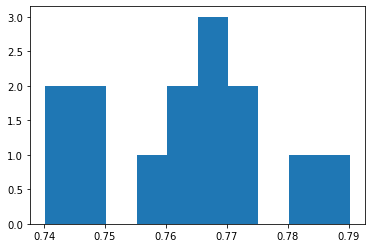

In [7]:
plt.hist(clinical.loc[clinical['sampleID'].isin(['TARGET-30-PAPVFD-01A', 'TARGET-30-PANUKV-01A', 'TARGET-30-PANLET-01A',
       'TARGET-30-PASCUF-01A', 'TARGET-30-PARDYU-01A', 'TARGET-30-PAPKXS-01A',
       'TARGET-30-PASMNT-01A', 'TARGET-30-PATEPF-01A', 'TARGET-30-PANBMJ-01A',
       'TARGET-30-PALHVD-01A', 'TARGET-30-PATDWN-01A', 'TARGET-30-PATNKP-01A',
       'TARGET-30-PARETE-01A', 'TARGET-30-PALSAE-01A']),'c_beta'])

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='TARGET-30-PANBSP-01A', ylabel='Count'>

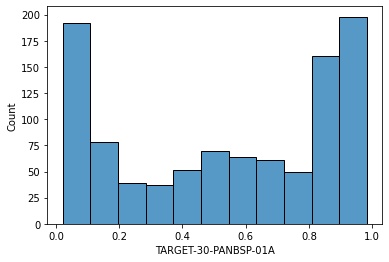

In [8]:
beta_values_Clock = pd.read_table(os.path.join(proj_dir, 'NBL.methyl.antiNonIterClustNotStuck_sites.tsv'), index_col=0)
sns.histplot(beta_values_Clock[clinical['c_beta'].sort_values().index[0] + '-01A'])

## Make Figures

In [77]:
## Configure graph
sf = pc_consts['sf']
figsize = np.array([7, 6])
sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

In [12]:
# ## Must set dataframe names for use of saveBoxPlotNew and saveCorrelationPlot

# clinical['TCGA'].name = 'TCGA'
# clinical['Lund'].name = 'Lund'

### 3 example tumors

In [13]:
clinical.loc[clinical['c_beta'] < clinical['c_beta'].quantile(0.25), 'sampleID']
clinical.loc[(clinical['c_beta'] > clinical['c_beta'].quantile(0.4)) & (clinical['c_beta'] < clinical['c_beta'].quantile(0.6)), 'sampleID']
clinical.loc[clinical['c_beta'] > clinical['c_beta'].quantile(0.75), 'sampleID']

submitter_id
TARGET-30-PASXRJ    0.874343
TARGET-30-PASWIJ    0.847628
TARGET-30-PASGAP    0.862660
TARGET-30-PALKKV    0.848688
TARGET-30-PAMLNB    0.846505
TARGET-30-PAPICY    0.850386
TARGET-30-PASWYR    0.862462
TARGET-30-PARBLH    0.854532
TARGET-30-PAPVRN    0.887433
TARGET-30-PAPUJU    0.876746
TARGET-30-PAIVMJ    0.847568
TARGET-30-PARJVP    0.845236
TARGET-30-PASBEN    0.873692
TARGET-30-PARUXY    0.843452
TARGET-30-PASFIC    0.845126
TARGET-30-PASJZC    0.842124
TARGET-30-PASCFC    0.858481
TARGET-30-PASCTR    0.847636
TARGET-30-PASMJG    0.852539
TARGET-30-PAIFXV    0.847835
TARGET-30-PARDUJ    0.845097
TARGET-30-PASDZJ    0.843063
TARGET-30-PAPKWN    0.840640
TARGET-30-PANZPV    0.875435
TARGET-30-PAPEFE    0.843754
TARGET-30-PATDXC    0.844405
TARGET-30-PARCET    0.842403
TARGET-30-PAPWUC    0.852031
TARGET-30-PAPSKM    0.849629
TARGET-30-PAPTLD    0.870014
TARGET-30-PARCWT    0.862397
TARGET-30-PAKYZS    0.875397
TARGET-30-PALBFW    0.859643
TARGET-30-PALETP    0.843377
T

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


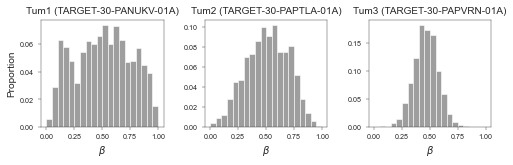

In [38]:
## Plot beta value distriubtions for 3 example tumors

beta_values_Clock = pd.read_table(
    os.path.join(pc_consts['official_indir'], 'TARGET', 'NBL.methyl.antiNonIterClustNotStuck_sites.tsv'),
    index_col=0)

sample_list = {
    'Tum1':'TARGET-30-PANUKV-01A',
    'Tum2':'TARGET-30-PAPTLA-01A',
    'Tum3':'TARGET-30-PAPVRN-01A'
}

pc_util.plotTumorWise(beta_values=beta_values_Clock, sample_list=[sample_list[tum] for tum in sample_list],
                     suptitle='', xlabel='$β$', title_formats=[tum + ' ({})' for tum in sample_list],
                     outfile=True, outdir=figure_outdir, outfile_name='example_tumors.pdf',
                     choose_random=False, color=pc_consts['palette_jco'][2], bins=20,
                     figsize=figsize * [2.45, 0.8], text_fontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], opacity=pc_consts['opacity'], sf=sf,
                     tight_layout_pad=0.2
             )

In [ ]:

pc_util.plotTumorWise(beta_values=beta_values_Clock,
#                      sample_list = clinical.loc[clinical['c_beta'] < clinical['c_beta'].quantile(0.25), 'sampleID'].values,
#                      sample_list = clinical.loc[(clinical['c_beta'] > clinical['c_beta'].quantile(0.4)) & (clinical['c_beta'] < clinical['c_beta'].quantile(0.6)), 'sampleID'],
                      sample_list = clinical.loc[clinical['c_beta'] > clinical['c_beta'].quantile(0.75), 'sampleID'],
                     suptitle='', xlabel='β',
#                       title_formats=[tum + ' ({})' for tum in sample_list],
                     outfile=False,
                     choose_random=False, color=pc_consts['palette_jco'][2], bins=20,
                     figsize=figsize * [2.3, 8], text_fontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], opacity=pc_consts['opacity'], sf=sf,
                     tight_layout_pad=0.2
             )

# $c_\beta$ distribution

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


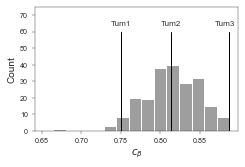

In [41]:
plot_data = clinical.loc[clinical['in_analysis_dataset'], 'c_beta']

# Create plot
fig, ax = plt.subplots(figsize=figsize * [1.3, 0.95] * sf)
sns.histplot(ax=ax, x=plot_data,
             color=pc_consts['palette_jco'][2], alpha=pc_consts['opacity'])


# Customize figure
ax.set_xlabel(r'$c_\beta$', fontsize=pc_consts['labelfontsize']*sf)
ax.set_ylabel('Count', fontsize=pc_consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=pc_consts['ticksfontsize'] * sf, width=sf, length=8 * sf)


# Mark (with vertical lines) the c_beta values of three
#   example tumors from plot in the previous cell
line_color = 'black'
tumor_heights = [0.8, 0.8, 0.8]

x_0 = clinical.loc[pc_util.sampleToPatientID(sample_list['Tum1']), 'c_beta']
x_1 = clinical.loc[pc_util.sampleToPatientID(sample_list['Tum2']), 'c_beta']
x_2 = clinical.loc[pc_util.sampleToPatientID(sample_list['Tum3']), 'c_beta']

ax.axvline(x=x_0, ymax=tumor_heights[0], lw=2.5 * sf, color=line_color)
ax.axvline(x=x_1, ymax=tumor_heights[1], lw=2.5 * sf, color=line_color)
ax.axvline(x=x_2, ymax=tumor_heights[2], lw=2.5 * sf, color=line_color)

# Customize figure
ax.set_xlabel('$c_β$', fontsize=pc_consts['labelfontsize'] * sf)
ax.set_ylabel('Count', fontsize=pc_consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=pc_consts['ticksfontsize'] * sf, width=sf, length=8 * sf)
ax.set_ylim(top=75)

# Widen plot a little
xlim = ax.get_xlim()
width = xlim[1] - xlim[0]
ax.set_xlim(left = xlim[0] - width/20)

# Annotate the vertical lines with text for all 3 tumors
y_height = ax.get_ylim()[1]

ax.text(x_0, (tumor_heights[0]+0.05)*y_height,
        'Tum1', color=line_color,
        ha="center", fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf, alpha=pc_consts['opacity']
       )
ax.text(x_1, (tumor_heights[1]+0.05)*y_height,
        'Tum2', color=line_color,
        ha="center", fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf, alpha=pc_consts['opacity']
       )
ax.text(x_2-0.005, (tumor_heights[2]+0.05)*y_height,
        'Tum3', color=line_color,
        ha="center", fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf, alpha=pc_consts['opacity']
       )

# Save figure
fig.savefig(os.path.join(figure_outdir, 'c_beta_distribution.pdf'), format='pdf', pad_inches=0.1)

# Covariate Analysis

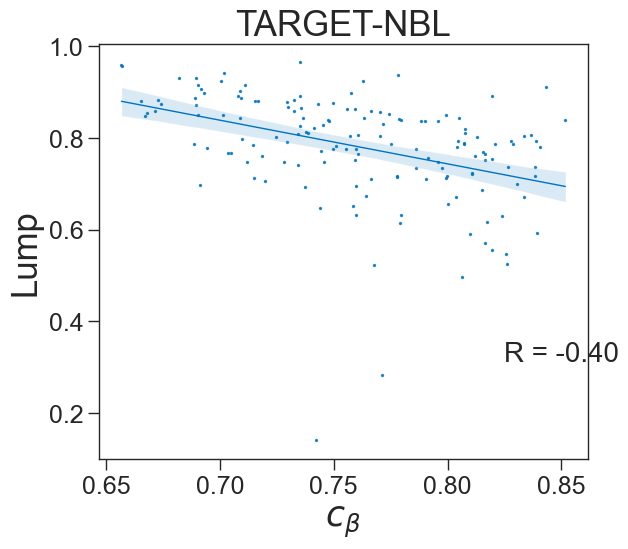

In [107]:
pc_util.saveCorrelationPlot(clinical, var_y='LUMP', restrict=True,
                           var_x='c_beta',
                             outfile=False,
                           text_x=0.85, text_y=0.3,
                           figsize=figsize * 0.9, labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=2,
                           color=pc_consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

In [108]:
pc_util.getCorrelation(clinical, 'LUMP', 'c_beta')

LinregressResult(slope=np.float64(-0.9529198579721195), intercept=np.float64(1.5054994532803814), rvalue=np.float64(-0.4018524112017764), pvalue=np.float64(3.14959267014387e-07), stderr=np.float64(0.17789018602603682), intercept_stderr=np.float64(0.135632698972839))

In [109]:
pc_util.getCorrelation(clinical, 'LUMP', 'c_beta', use_samples=clinical.index[clinical['LUMP'] > 0.5])

LinregressResult(slope=np.float64(-0.9417491505630115), intercept=np.float64(1.506373725850637), rvalue=np.float64(-0.49776933563996345), pvalue=np.float64(1.2215451709227495e-10), stderr=np.float64(0.13580155738129832), intercept_stderr=np.float64(0.10351104766221639))

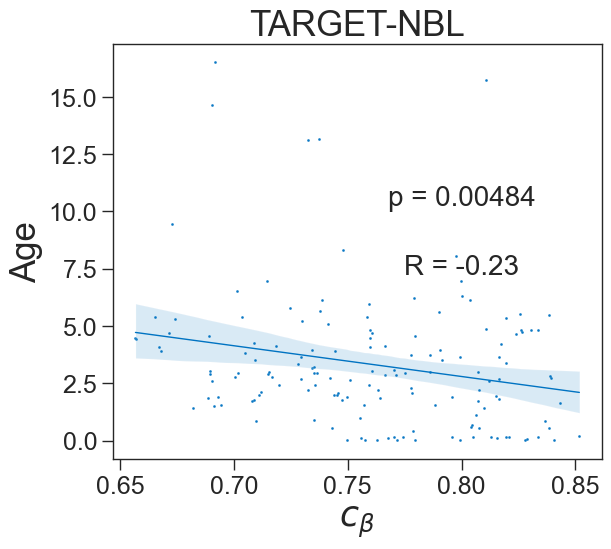

In [114]:
corr, p_value = stats.pearsonr(clinical['c_beta'], clinical['Age'])

fig, ax = plt.subplots(figsize=figsize * 0.9)
pc_util.saveCorrelationPlot(clinical, var_y='Age', restrict=True,
                            var_x='c_beta', outfile=False,
                            text_x=0.8, text_y=7,
                            ax=ax,
                            figsize=figsize * 0.9, labelfontsize=pc_consts['labelfontsize'], 
                            ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=1,
                            color=pc_consts['palette_jco'][0], 
                            line_kws={'linewidth': 1 * sf})

ax.text(0.8, 10, f'p = {p_value:.3g}', ha="center", va="bottom",
        fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf)

plt.show()

In [115]:
def getVarMeans(col):
    return clinical.groupby(col)['c_beta'].agg(['count', 'mean']).sort_values('count', ascending=False)

In [116]:
getVarMeans('primary_site')

,count,mean
primary_site,,
Adrenal gland,74,0.759595
Other and ill-defined sites,37,0.758550
Retroperitoneum and peritoneum,16,0.744699
Unknown,8,0.782377
"Heart, mediastinum, and pleura",4,0.790232
Kidney,4,0.751771
Peripheral nerves and autonomic nervous system,2,0.725412
"Connective, subcutaneous and other soft tissues",1,0.759771
Liver and intrahepatic bile ducts,1,0.830646


/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,
/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,


<Axes: xlabel='inss stage', ylabel='$c_β$'>

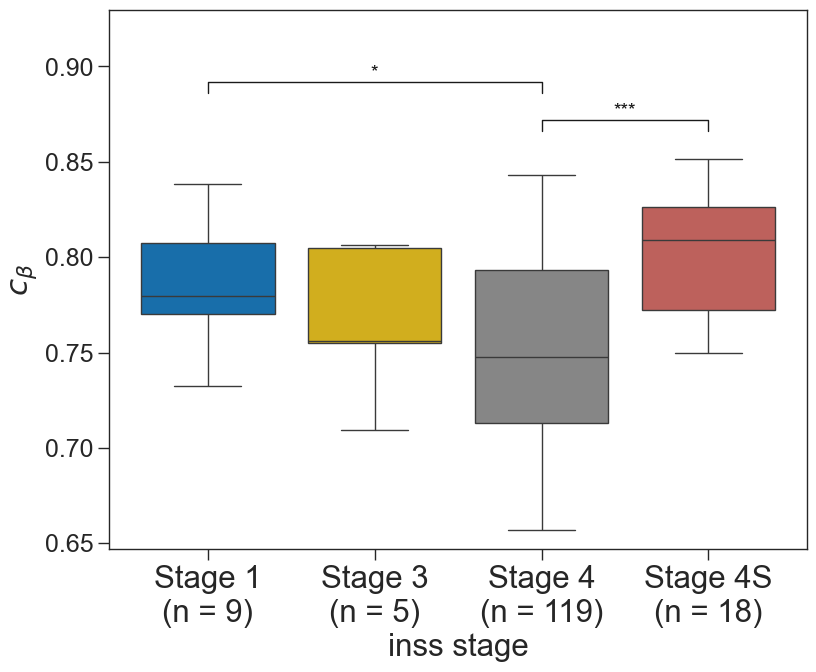

In [118]:
pc_util.saveBoxPlotNew(clinical, 'inss_stage', restrict=False,
                   var_y='c_beta', outfile=False, title=False, signif_bar_heights = 0.02,
                   palette=pc_consts['palette_jco'], xlabel='inss stage',
                   figsize=np.array([9, 7]), labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])

/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,
/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,


<Axes: xlabel='cog_neuroblastoma_risk_group', ylabel='$c_β$'>

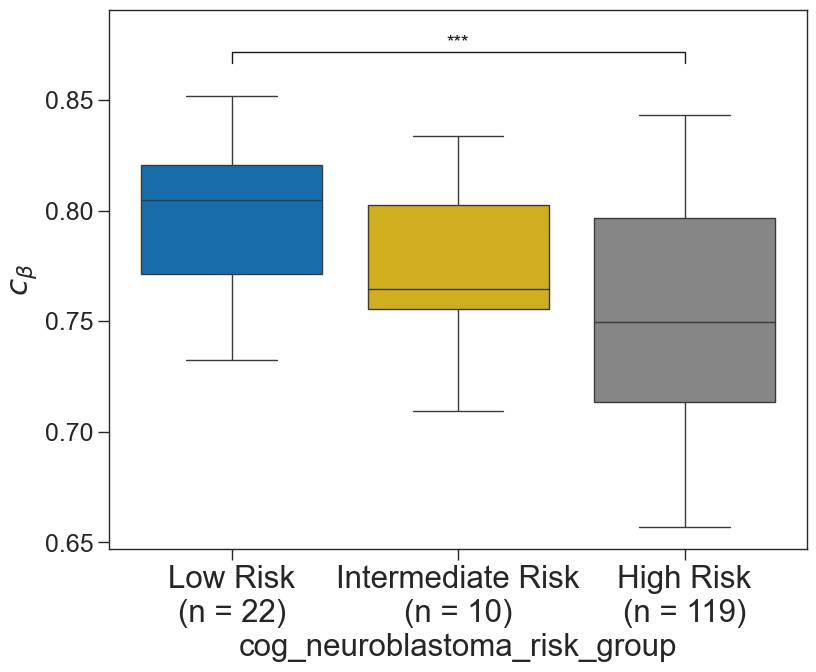

In [119]:
cat_order = ["Low Risk", "Intermediate Risk", "High Risk"]

pc_util.saveBoxPlotNew(clinical, 'cog_neuroblastoma_risk_group', restrict=False,
                   var_y='c_beta', outfile=False, title=False, use_groups = cat_order, signif_bar_heights = 0.02,
                   palette=pc_consts['palette_jco'], xlabel='cog_neuroblastoma_risk_group',
                   figsize=np.array([9, 7]), labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])

/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,
/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,


<Axes: xlabel='mitosis_karyorrhexis_index', ylabel='$c_β$'>

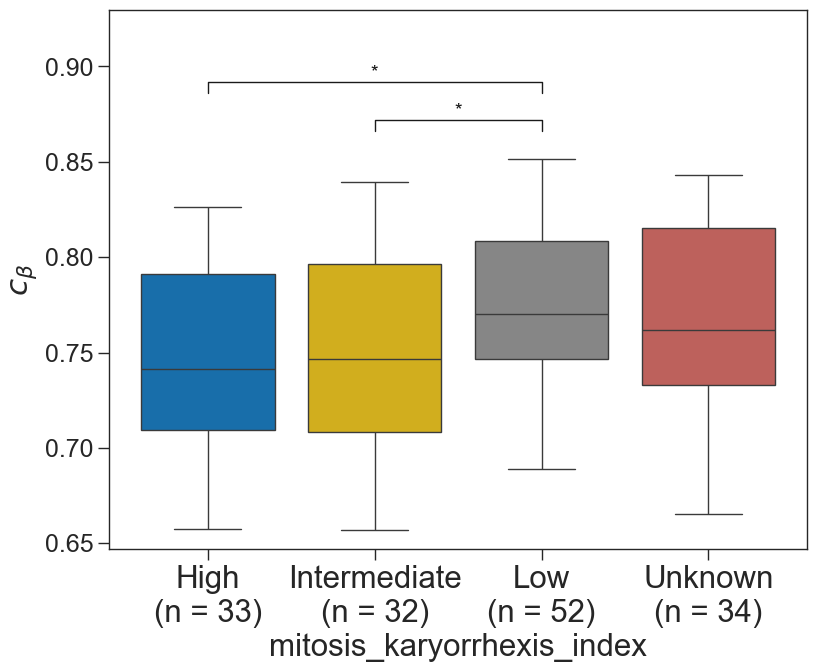

In [120]:
pc_util.saveBoxPlotNew(clinical, 'mitosis_karyorrhexis_index', restrict=False,
                   var_y='c_beta', outfile=False, title=False, signif_bar_heights = 0.02,
                   palette=pc_consts['palette_jco'], xlabel='mitosis_karyorrhexis_index',
                   figsize=np.array([9, 7]), labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])

/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,
/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,


<Axes: xlabel='inpc_grade', ylabel='$c_β$'>

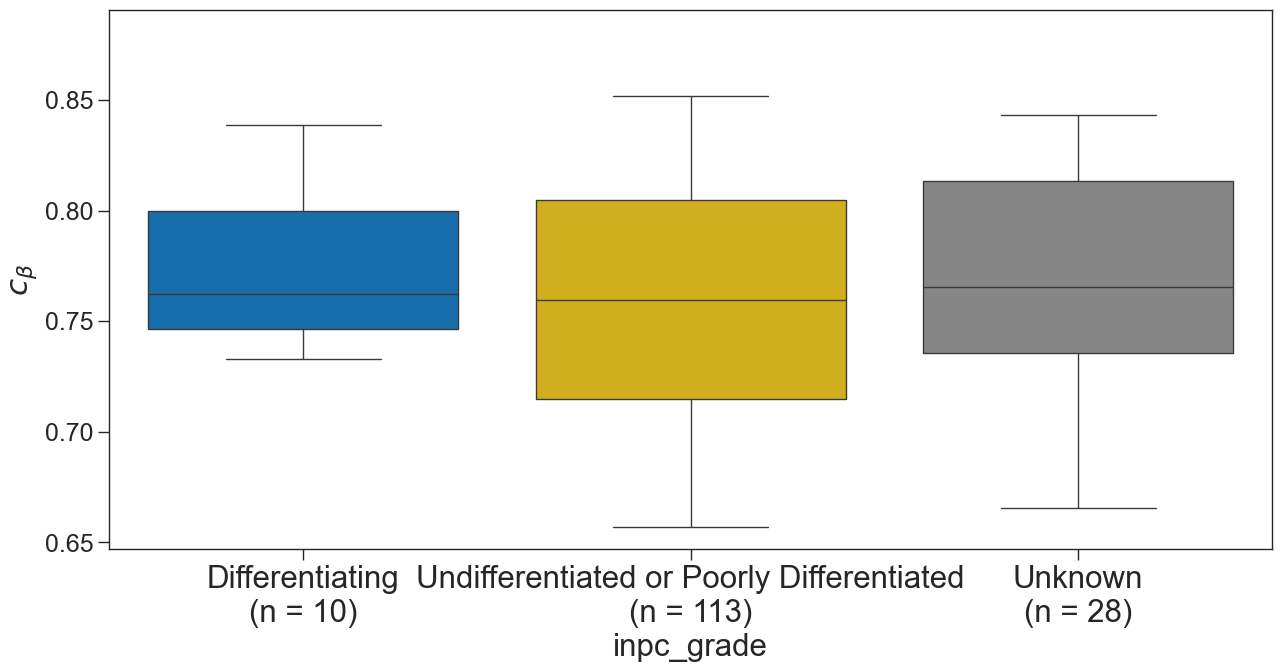

In [121]:
pc_util.saveBoxPlotNew(clinical, 'inpc_grade', restrict=False,
                   var_y='c_beta', outfile=False, title=False, signif_bar_heights = 0.02,
                   palette=pc_consts['palette_jco'], xlabel='inpc_grade',
                   figsize=np.array([15, 7]), labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])

/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,
/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,


<Axes: xlabel='icd_10_code', ylabel='$c_β$'>

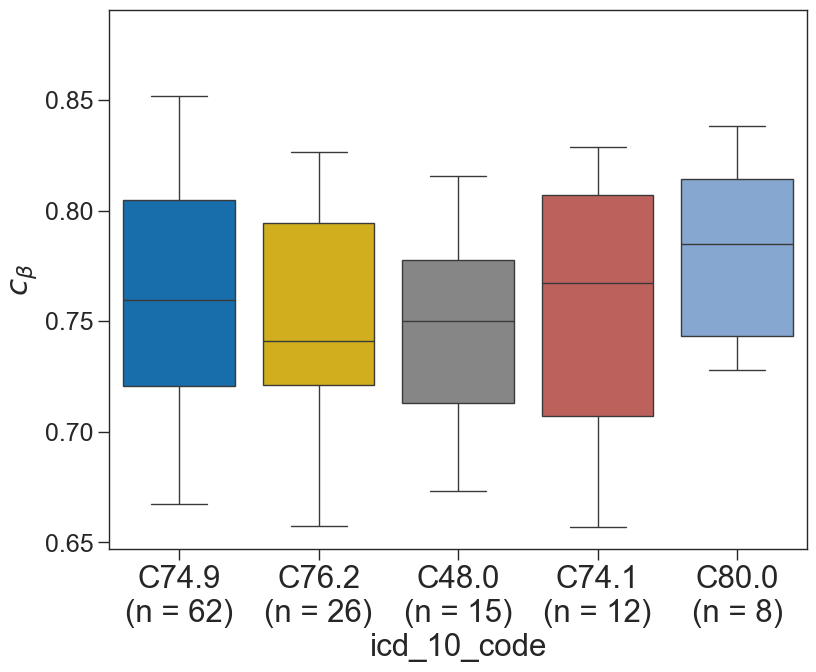

In [122]:
pc_util.saveBoxPlotNew(clinical, 'icd_10_code', restrict=False,
                   var_y='c_beta', outfile=False, title=False, signif_bar_heights = 0.02,
                   palette=pc_consts['palette_jco'], xlabel='icd_10_code',
                       use_groups=clinical['icd_10_code'].value_counts().sort_values(ascending=False).index[:5].values,
                   figsize=np.array([9, 7]), labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])

/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,
/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,


<Axes: title={'center': 'c_beta by Race'}, xlabel='race_3cat', ylabel='$c_β$'>

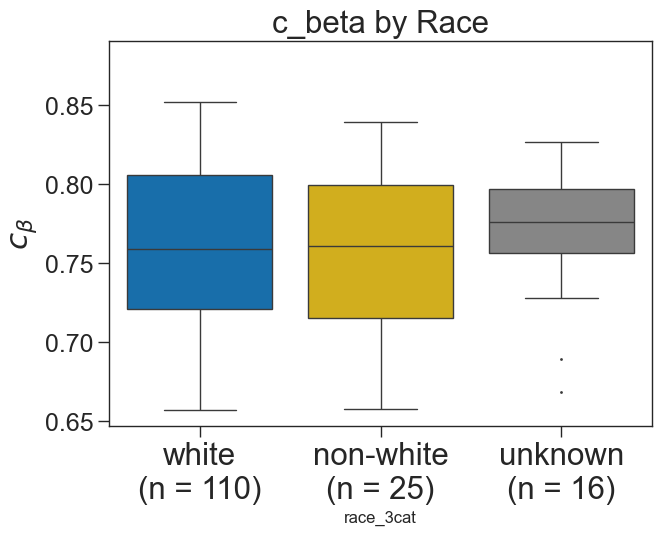

In [123]:
def map_race_to_3cat(race_value):
    """
    Convert each race entry into 'white', 'nonwhite', or 'unknown'.
    """
    if pd.isna(race_value) or str(race_value).lower() == 'unknown':
        return 'unknown'
    elif str(race_value).lower() == 'white':
        return 'white'
    else:
        return 'non-white'

# Apply this mapping to your 'race' column
clinical['race_3cat'] = clinical['race'].apply(map_race_to_3cat)

# Option A: Make it a categorical with the correct order
cat_order = ['white', 'non-white', 'unknown']
clinical['race_3cat'] = pd.Categorical(
    clinical['race_3cat'],
    categories=cat_order,
    ordered=True
)

pc_util.saveBoxPlotNew(
    sample_annotations = clinical,
    var_cat           = 'race_3cat',
    var_y             = 'c_beta',
    restrict          = False,
    use_groups        = cat_order,
    outdir            = '.',
    outfile           = False,
    title             = False,
    custom_title      = 'c_beta by Race',
    palette           = pc_consts['palette_jco'],
    xlabel            = 'Race',
    figsize           = np.array([7, 5]),
    labelfontsize     = pc_consts['labelfontsize'] * 0.9,
    ticksfontsize     = pc_consts['ticksfontsize'],
    sf                = sf,
    linewidth         = pc_consts['linewidth'],
    fliersize         = pc_consts['fliersize']
)


/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,
/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,


<Axes: xlabel='gender', ylabel='$c_β$'>

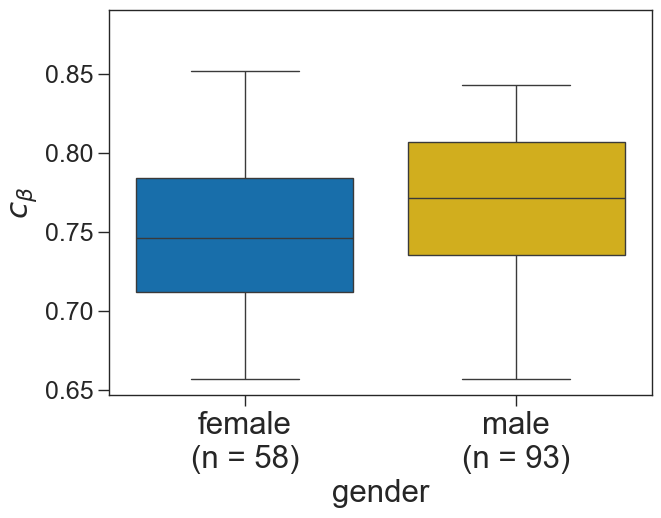

In [124]:
pc_util.saveBoxPlotNew(clinical, 'gender', restrict=False,
                   var_y='c_beta', outfile=False, title=False, signif_bar_heights = 0.02,
                   palette=pc_consts['palette_jco'], xlabel='gender',
                   figsize=np.array([7, 5]), labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])

/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,
/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,


<Axes: xlabel='ethnicity', ylabel='$c_β$'>

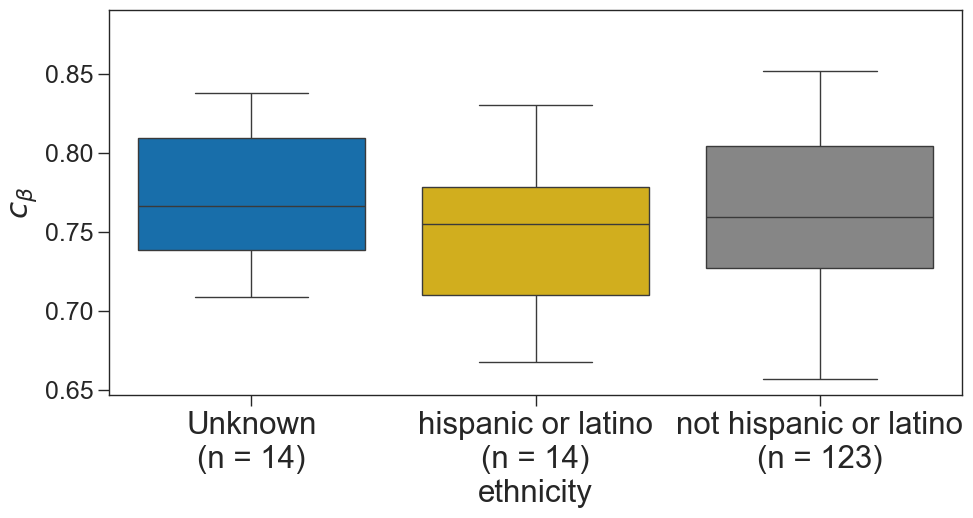

In [78]:
pc_util.saveBoxPlotNew(clinical, 'ethnicity', restrict=False,
                   var_y='c_beta', outfile=False, title=False, signif_bar_heights = 0.02,
                   palette=pc_consts['palette_jco'], xlabel='ethnicity',
                   figsize=np.array([11, 5]), labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])

/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,
/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,


<Axes: xlabel='primary_diagnosis', ylabel='$c_β$'>

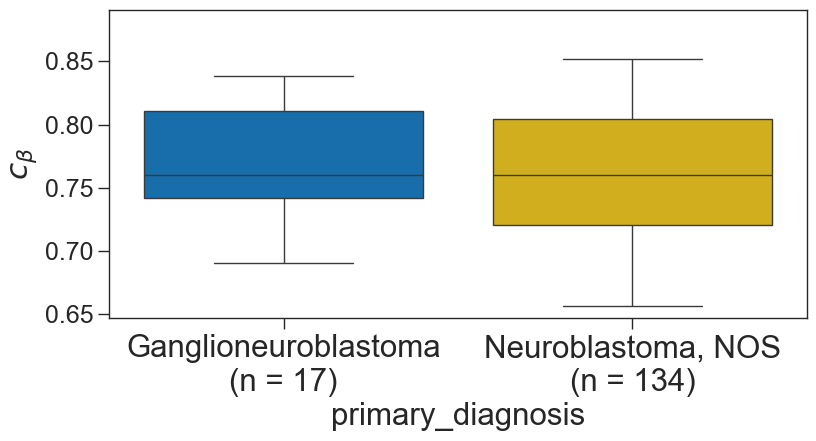

In [79]:
pc_util.saveBoxPlotNew(clinical, 'primary_diagnosis', restrict=False,
                   var_y='c_beta', outfile=False, title=False, signif_bar_heights = 0.02,
                   palette=pc_consts['palette_jco'], xlabel='primary_diagnosis',
                   figsize=np.array([9, 4]), labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])

/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,
/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,


<Axes: xlabel='vital_status', ylabel='$c_β$'>

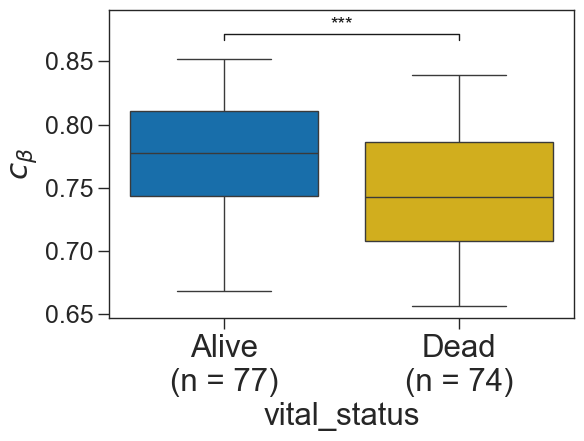

In [81]:
pc_util.saveBoxPlotNew(clinical, 'vital_status', restrict=False,
                   var_y='c_beta', outfile=False, title=False, signif_bar_heights = 0.02,
                   palette=pc_consts['palette_jco'], xlabel='vital_status',
                   figsize=np.array([6, 4]), labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])

In [82]:
pc_util.getCorrelation(clinical, 'Age', 'c_beta')

LinregressResult(slope=np.float64(-13.421923660083113), intercept=np.float64(13.536316269510161), rvalue=np.float64(-0.22815244015844602), pvalue=np.float64(0.004839217292704344), stderr=np.float64(4.692328597505232), intercept_stderr=np.float64(3.5776745550983886))

In [83]:
print(pc_util.getCorrelation(clinical, 'Age', 'c_beta'))
print(pc_util.getCorrelation(clinical, 'Age', 'c_beta', use_samples=clinical.index[clinical['Age'] < 7.5]))

LinregressResult(slope=np.float64(-13.421923660083113), intercept=np.float64(13.536316269510161), rvalue=np.float64(-0.22815244015844602), pvalue=np.float64(0.004839217292704344), stderr=np.float64(4.692328597505232), intercept_stderr=np.float64(3.5776745550983886))
LinregressResult(slope=np.float64(-8.07137870393231), intercept=np.float64(8.971147598717957), rvalue=np.float64(-0.21282017040743265), pvalue=np.float64(0.010712890444934252), stderr=np.float64(3.120761401895775), intercept_stderr=np.float64(2.3838545711259))


In [84]:
clinical

,project,disease_type,primary_site,submitter_id.1,inss_stage,days_to_diagnosis,created_datetime,treatments,last_known_disease_status,tissue_or_organ_of_origin,...,in_CpG_dataset,reason_methyl_and_purity,in_analysis_dataset,note_multiple_methyl,sampleID,c_beta,c_beta_traditional,LUMP,Age,race_3cat
submitter_id,,,,,,,,,,,,,,,,,,,,,
TARGET-30-PASUCB,TARGET-NBL,Neuroepitheliomatous Neoplasms,Adrenal gland,TARGET-30-PASUCB,Stage 4,0.0,2016-04-25T17:01:49.369915-05:00,"c(\ANBL0532\"", \""ANBL00B1\"", \""ANBL0032\"", \""A...",NaN,"Adrenal gland, NOS",...,True,False,True,False,TARGET-30-PASUCB-01A,0.700583,0.649866,0.924931,2.761644,white
TARGET-30-PASNPG,TARGET-NBL,Neuroepitheliomatous Neoplasms,Other and ill-defined sites,TARGET-30-PASNPG,Stage 3,0.0,2016-04-25T16:57:09.436943-05:00,"c(\ANBL00B1\"", \""ANBL0531\""), c(\""2024-03-13T1...",NaN,Other ill-defined sites,...,True,False,True,False,TARGET-30-PASNPG-01A,0.709532,0.662856,0.796474,0.871233,non-white
TARGET-30-PARNEE,TARGET-NBL,Neuroepitheliomatous Neoplasms,Adrenal gland,TARGET-30-PARNEE,Stage 4,0.0,2016-04-25T16:44:22.906788-05:00,"ANBL00B1, 2024-03-13T17:13:56.180548-05:00, 72...",NaN,"Adrenal gland, NOS",...,True,False,True,False,TARGET-30-PARNEE-01A,0.701682,0.662661,0.940717,2.934247,white
TARGET-30-PALXTB,TARGET-NBL,Neuroepitheliomatous Neoplasms,Adrenal gland,TARGET-30-PALXTB,Stage 4,0.0,2016-04-25T16:35:47.858032-05:00,"c(\ALTE05N1\"", \""A3973\"", \""ANBL00B1\""), c(\""2...",NaN,Medulla of adrenal gland,...,True,False,True,False,TARGET-30-PALXTB-01A,0.807062,0.765135,0.785620,1.739726,white
TARGET-30-PAMMXF,TARGET-NBL,Neuroepitheliomatous Neoplasms,Adrenal gland,TARGET-30-PAMMXF,Stage 4,0.0,2016-04-25T16:36:44.389493-05:00,"ANBL00B1, 2024-03-13T17:13:56.180548-05:00, 58...",NaN,"Adrenal gland, NOS",...,True,False,True,False,TARGET-30-PAMMXF-01A,0.688997,0.647308,0.887105,4.550685,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TARGET-30-PALVVH,TARGET-NBL,Neuroepitheliomatous Neoplasms,Adrenal gland,TARGET-30-PALVVH,Stage 1,0.0,2016-04-25T16:35:32.850179-05:00,"c(\P9641\"", \""AADM01P1\"", \""ANBL00B1\""), c(\""2...",NaN,Medulla of adrenal gland,...,True,False,True,False,TARGET-30-PALVVH-01A,0.804176,0.764360,0.779090,0.600000,white
TARGET-30-PATYIL,TARGET-NBL,Neuroepitheliomatous Neoplasms,Other and ill-defined sites,TARGET-30-PATYIL,Stage 4,0.0,2016-04-25T17:27:05.368795-05:00,"c(\ANBL00B1\"", \""ANBL0531\""), c(\""2024-03-13T1...",NaN,"Abdomen, NOS",...,True,False,True,False,TARGET-30-PATYIL-01A,0.735402,0.689974,0.891580,0.898630,white
TARGET-30-PAPBGH,TARGET-NBL,Neuroepitheliomatous Neoplasms,Adrenal gland,TARGET-30-PAPBGH,Stage 4,0.0,2016-04-25T16:39:29.598191-05:00,"c(\ANBL0032\"", \""A3973\"", \""ANBL00B1\""), c(\""2...",NaN,"Adrenal gland, NOS",...,True,False,True,False,TARGET-30-PAPBGH-01A,0.735418,0.714002,0.964284,2.942466,non-white


<Axes: xlabel='Age', ylabel='Count'>

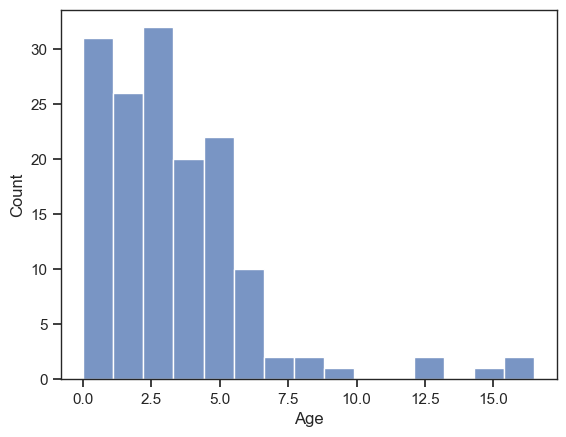

In [85]:
sns.histplot(clinical['Age'])

/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,
/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/src/util.py:154: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, data=plot_data, x=var_cat, y=var_y,


<Axes: xlabel='Age Category', ylabel='$c_β$'>

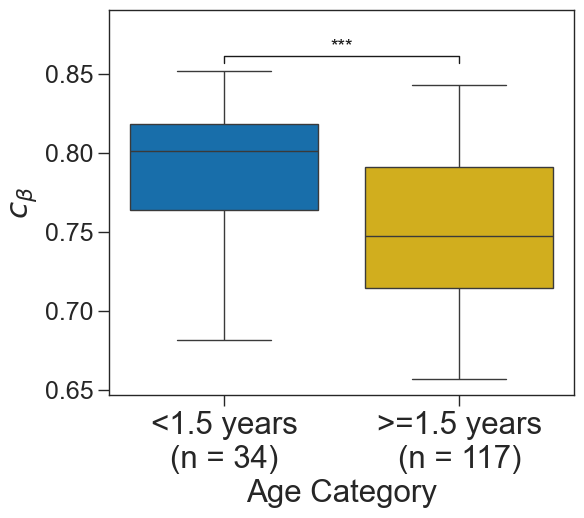

In [86]:
clinical['Age Category'] = (clinical['Age'] >= 1.5).map({True:'>=1.5 years', False:'<1.5 years'})
pc_util.saveBoxPlotNew(clinical, 'Age Category', restrict=False,
                   var_y='c_beta', outfile=False, title=False, signif_bar_heights = 0.01,
                   palette=pc_consts['palette_jco'], xlabel='Age Category',
                   figsize=np.array([6, 5]), labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])

In [87]:
clinical.loc[clinical['vital_status'] == 'Dead'].iloc[0]

project                                                                     TARGET-NBL
disease_type                                            Neuroepitheliomatous Neoplasms
primary_site                                                             Adrenal gland
submitter_id.1                                                        TARGET-30-PARNEE
inss_stage                                                                     Stage 4
days_to_diagnosis                                                                  0.0
created_datetime                                      2016-04-25T16:44:22.906788-05:00
treatments                           ANBL00B1, 2024-03-13T17:13:56.180548-05:00, 72...
last_known_disease_status                                                          NaN
tissue_or_organ_of_origin                                           Adrenal gland, NOS
days_to_last_follow_up                                                             NaN
age_at_diagnosis                           

# Beta values

In [88]:
beta_values_Clock = pd.read_table(os.path.join(proj_dir, 'NBL.methyl.traditional_sites.tsv'), index_col=0)

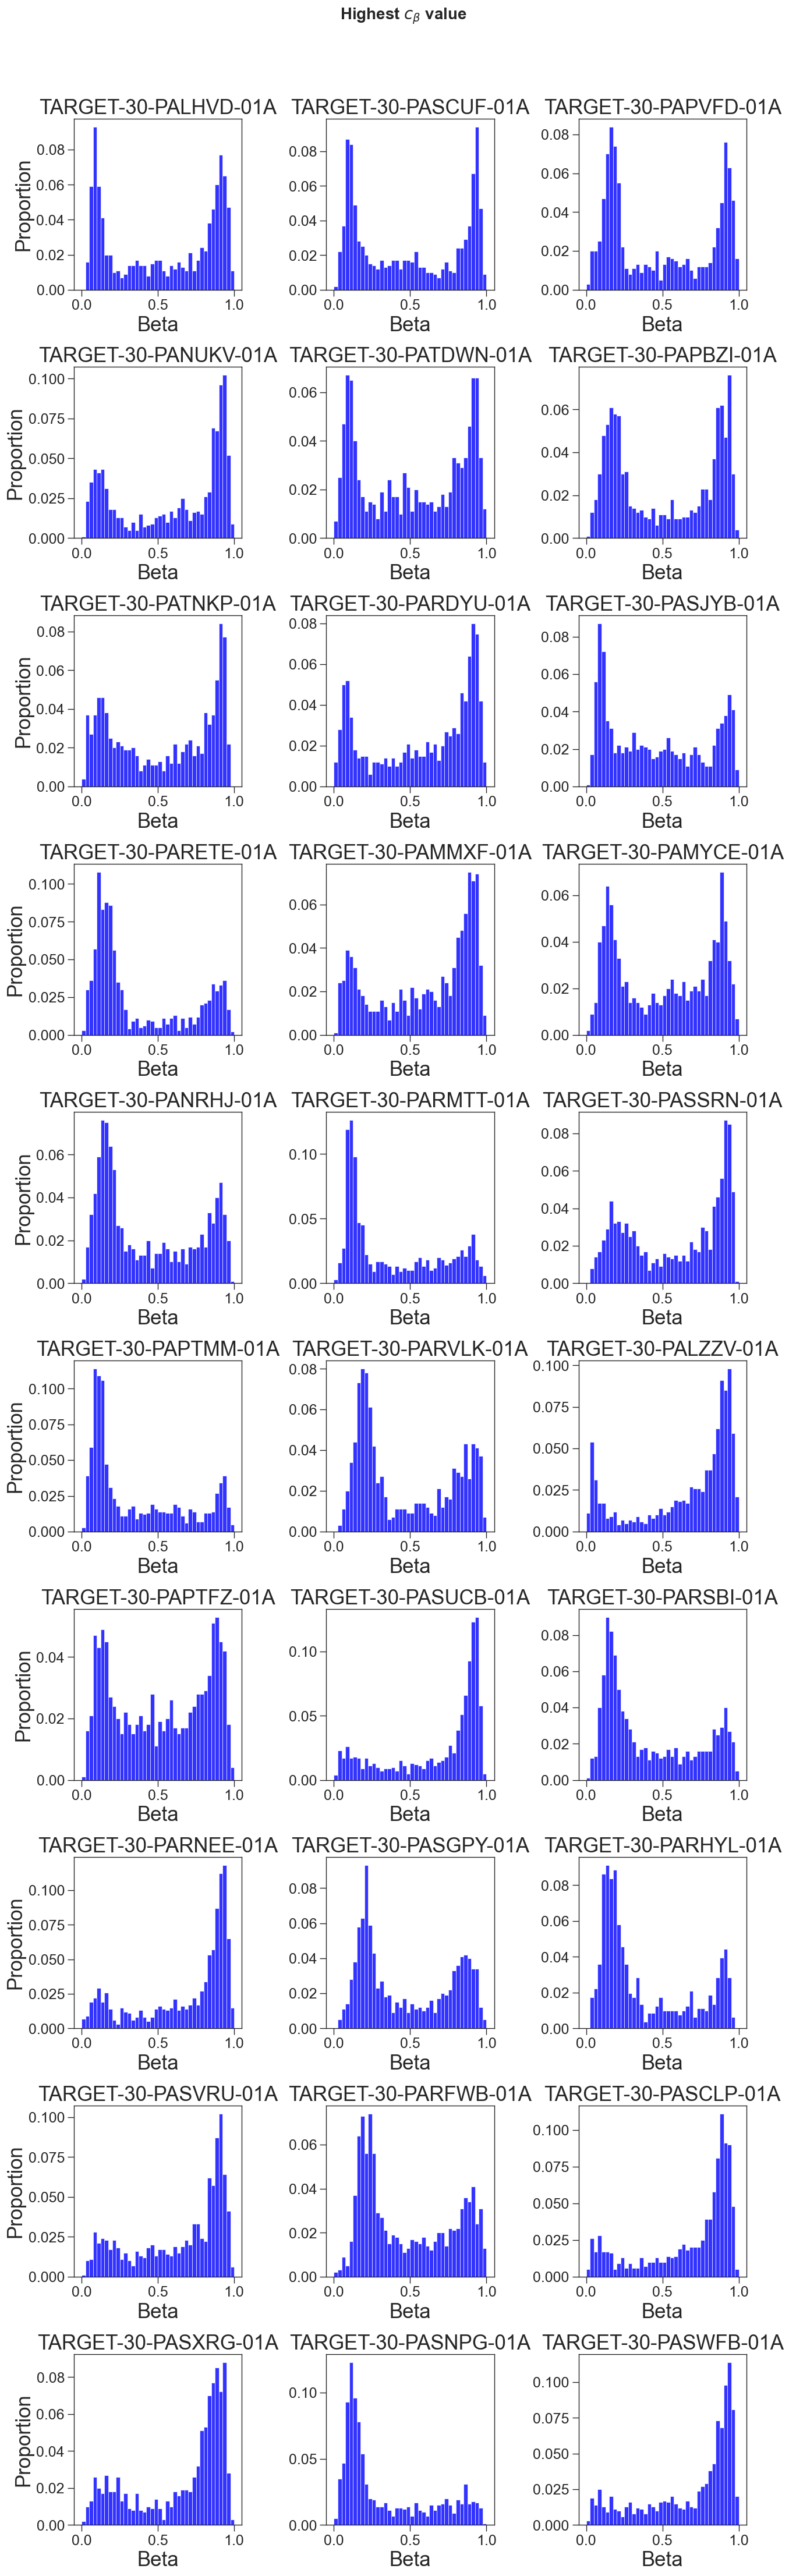

In [89]:
n_samps = 30

# Plot Clock beta values youngest tumors and save plot
youngest = c_beta.sort_values().index[:n_samps]
pc_util.plotTumorWise(
    beta_values_Clock,
    data_obj = "beta_decomp",
    n_samps=n_samps, ncols=3,
    choose_random=False,
    sample_list=youngest,
    figsize=figsize * [2, 4.5/18 * n_samps], text_fontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], opacity=pc_consts['opacity'], sf=1,
    tight_layout_pad=6, bins=40,
    suptitle='Highest $c_β$ value',
    outfile=True, outfile_name='NBL-youngest_tumors.pdf', outdir=figure_outdir
)

In [90]:
clinical.groupby('vital_status')['cog_neuroblastoma_risk_group'].value_counts().unstack()

cog_neuroblastoma_risk_group,High Risk,Intermediate Risk,Low Risk
vital_status,,,
Alive,46.0,9.0,22.0
Dead,73.0,1.0,NaN


In [91]:
clinical['Age']

submitter_id
TARGET-30-PASUCB    2.761644
TARGET-30-PASNPG    0.871233
TARGET-30-PARNEE    2.934247
TARGET-30-PALXTB    1.739726
TARGET-30-PAMMXF    4.550685
                      ...   
TARGET-30-PALVVH    0.600000
TARGET-30-PATYIL    0.898630
TARGET-30-PAPBGH    2.942466
TARGET-30-PAREGK    1.556164
TARGET-30-PAMZSH    0.863014
Name: Age, Length: 151, dtype: float64

In [92]:
clinical['Clock estimate'] = -np.log(1 - 2*clinical['c_beta']) / 2

/Users/grahamgumbert/myenv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [93]:
clinical['c_beta']

submitter_id
TARGET-30-PASUCB    0.700583
TARGET-30-PASNPG    0.709532
TARGET-30-PARNEE    0.701682
TARGET-30-PALXTB    0.807062
TARGET-30-PAMMXF    0.688997
                      ...   
TARGET-30-PALVVH    0.804176
TARGET-30-PATYIL    0.735402
TARGET-30-PAPBGH    0.735418
TARGET-30-PAREGK    0.788461
TARGET-30-PAMZSH    0.836455
Name: c_beta, Length: 151, dtype: float64

In [94]:
clinical['Clock estimate']

submitter_id
TARGET-30-PASUCB   NaN
TARGET-30-PASNPG   NaN
TARGET-30-PARNEE   NaN
TARGET-30-PALXTB   NaN
TARGET-30-PAMMXF   NaN
                    ..
TARGET-30-PALVVH   NaN
TARGET-30-PATYIL   NaN
TARGET-30-PAPBGH   NaN
TARGET-30-PAREGK   NaN
TARGET-30-PAMZSH   NaN
Name: Clock estimate, Length: 151, dtype: float64

(array([39., 50., 34., 17.,  4.,  2.,  0.,  2.,  1.,  2.]),
 array([-0.81039807,  0.85106956,  2.51253719,  4.17400482,  5.83547244,
         7.49694007,  9.1584077 , 10.81987533, 12.48134296, 14.14281058,
        15.80427821]),
 <BarContainer object of 10 artists>)

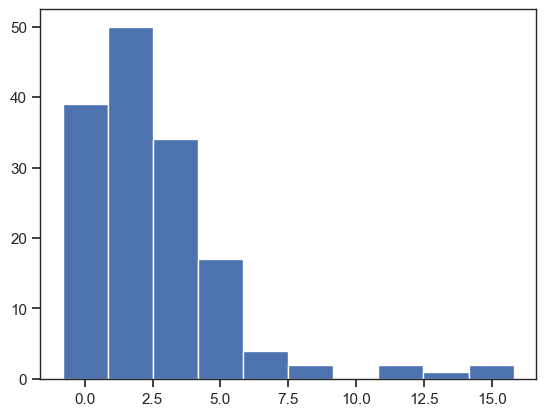

In [95]:
plt.hist(clinical['Age'] - clinical['c_beta'])

<Axes: xlabel='c_beta', ylabel='Age'>

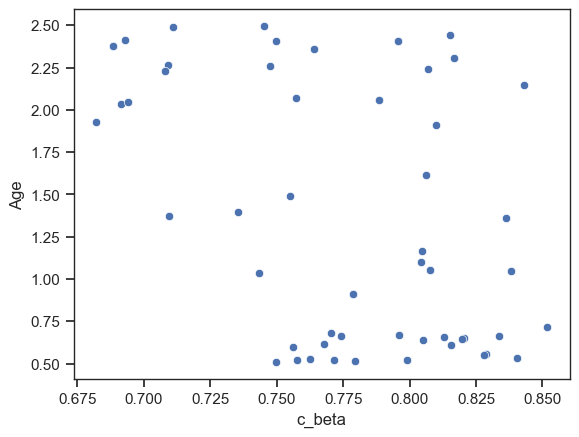

In [96]:
mask = clinical['Age'] < 2
sns.scatterplot(x=clinical.loc[mask, 'c_beta'], y=clinical.loc[mask, 'Age']+0.5)

In [97]:
mask.sum()

np.int64(52)

## Waterfall plot

In [79]:
help(ax.annotate)

Help on method annotate in module matplotlib.axes._axes:

annotate(text, xy, xytext=None, xycoords='data', textcoords=None, arrowprops=None, annotation_clip=None, **kwargs) method of matplotlib.axes._axes.Axes instance
    Annotate the point *xy* with text *text*.
    
    In the simplest form, the text is placed at *xy*.
    
    Optionally, the text can be displayed in another position *xytext*.
    An arrow pointing from the text to the annotated point *xy* can then
    be added by defining *arrowprops*.
    
    Parameters
    ----------
    text : str
        The text of the annotation.
    
    xy : (float, float)
        The point *(x, y)* to annotate. The coordinate system is determined
        by *xycoords*.
    
    xytext : (float, float), default: *xy*
        The position *(x, y)* to place the text at. The coordinate system
        is determined by *textcoords*.
    
    xycoords : single or two-tuple of str or `.Artist` or `.Transform` or callable, default: 'data'
    
  

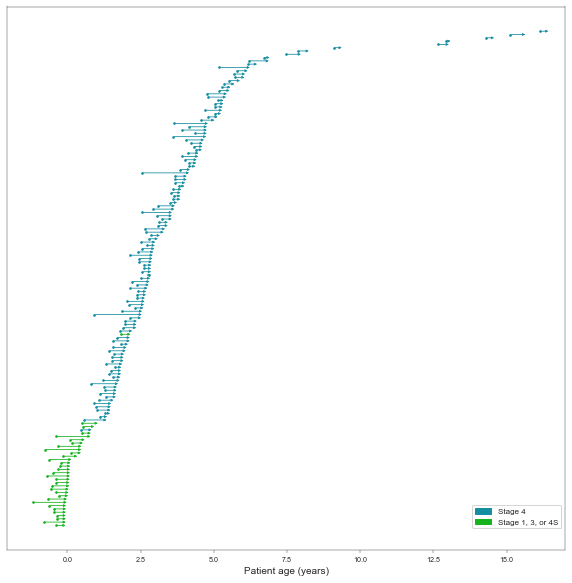

In [98]:
clinical = pd.read_csv('/Users/danielmonyak/Library/CloudStorage/Box-Box/PROJECT 06023: MolClocks/Neuroblastoma_Paper/0. PAPER/2. Figures/forDan.csv', index_col=0)
clinical['Stage 4'] = (clinical['inss_stage'] == 'Stage 4').map(lambda x:'Stage 4' if x else 'Stage 1, 3, or 4S')

fig, ax = plt.subplots(figsize=(10, 10))

# color_var = 'inss_stage'
# color_var = 'cog_neuroblastoma_risk_group'
color_var = 'Stage 4'

tumors_ordered = clinical.loc[clinical['in_analysis_dataset']].sort_values('Age').index
if color_var == 'inss_stage':
    color_dict = dict(zip(['Stage 1', 'Stage 3', 'Stage 4S', 'Stage 4'], pc_consts['palette_jco']))
else:
#     color_dict = dict(zip(clinical[color_var].unique(), pc_consts['palette_jco']))
    color_dict = dict(zip(clinical[color_var].unique(), ['#168ea1', '#17b31f']))


for i, tum in enumerate(tumors_ordered):
    x_points = [clinical.loc[tum, 'Age'] - clinical.loc[tum, 'calendar_age'] / 365, clinical.loc[tum, 'Age']]
    y_points = [i, i]
    color = color_dict[clinical.loc[tum, color_var]]
#     ax.plot(x_points, y_points, 'o-', linewidth=0.5*sf,
#             color=color_dict[clinical.loc[tum, color_var]], markersize=3*sf,
#             alpha=1)
    # Plot the circle on the left side
    ax.plot(x_points[0], y_points[0], 'o', markersize=4*sf, color=color)  # green circle

    # Draw the line with an arrowhead at the right side
    ax.annotate(
        '', 
        xy=(x_points[1], y_points[1]),
        xytext=(x_points[0]-0.05, y_points[0]),
        arrowprops=dict(arrowstyle='-|>', color=color,
                        linewidth=2*sf, mutation_scale=12*sf)
    )


patches = [mpatches.Patch(color=color_dict[group], label=group) for group in color_dict.keys()]
plots_x, plots_y = ax.get_position().get_points()[1]

fig.legend(handles=patches,
           loc='upper right',
           bbox_to_anchor=(plots_x, plots_y * 0.22),
           fontsize=0.8*pc_consts['labelfontsize'] * sf
          )

ax.set_xlabel('Patient age (years)', fontsize=pc_consts['labelfontsize']*sf)
ax.tick_params(axis='y', which='both', left=False, labelleft=False)  
ax.tick_params(axis='x', labelsize=pc_consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

# ax.axvline(x=0.2, color=pc_consts['palette_jco'][3], linestyle='--', linewidth=2)



# Save figure
fig.savefig(os.path.join(figure_outdir, 'swimmer_plot.pdf'), format='pdf', pad_inches=0.1)